In [57]:
import torch
from transformers import pipeline
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import json
import torch.nn.functional as F
from datetime import date


In [58]:
# Show full content of the column
pd.set_option('display.max_colwidth', 10)
pd.set_option('display.max_rows', 30)

In [59]:
# Download necessary NLTK resources
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/bbae/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [61]:
appstore_df = pd.read_csv("../data/appstore_reviews.csv")

In [62]:
appstore_df.shape

(7163, 15)

In [63]:
appstore_df.dtypes

id                              int64
type                           object
offset                        float64
n_batch                       float64
app_id                          int64
date                           object
developerResponse.id          float64
developerResponse.body         object
developerResponse.modified     object
review                         object
rating                        float64
isEdited                         bool
userName                       object
title                          object
name                           object
dtype: object

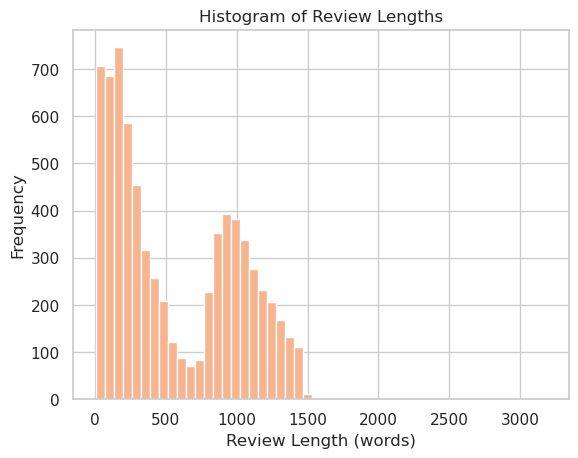

In [64]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Histogram of the length of reviews
ax.hist(appstore_df["review"].str.len(), bins=50)

# Set the title, x-label, and y-label
ax.set_title("Histogram of Review Lengths")
ax.set_xlabel("Review Length (words)")
ax.set_ylabel("Frequency")

# Show the plot
plt.show()

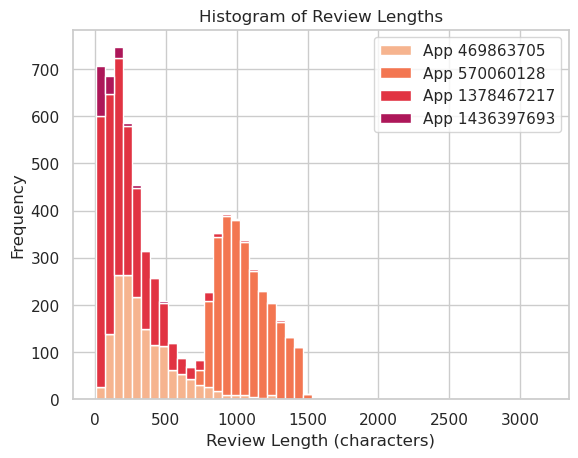

In [65]:
# Create a figure and axis object
fig, ax = plt.subplots()
bins = 50
hist_values = []
groups = appstore_df.groupby("app_id")
for app_id, group in groups:
    # Get the review lengths for the current app_id group
    review_lengths = group["review"].str.len()
    hist_values.append(review_lengths)

# Create a stacked histogram
ax.hist(hist_values, bins=bins, density=False, histtype='bar', stacked=True)
    
# Set the title, x-label, and y-label
ax.set_title("Histogram of Review Lengths")
ax.set_xlabel("Review Length (characters)")
ax.set_ylabel("Frequency")
ax.legend([f"App {app_id}" for app_id  in groups.groups.keys()])

# Show the plot
plt.show()

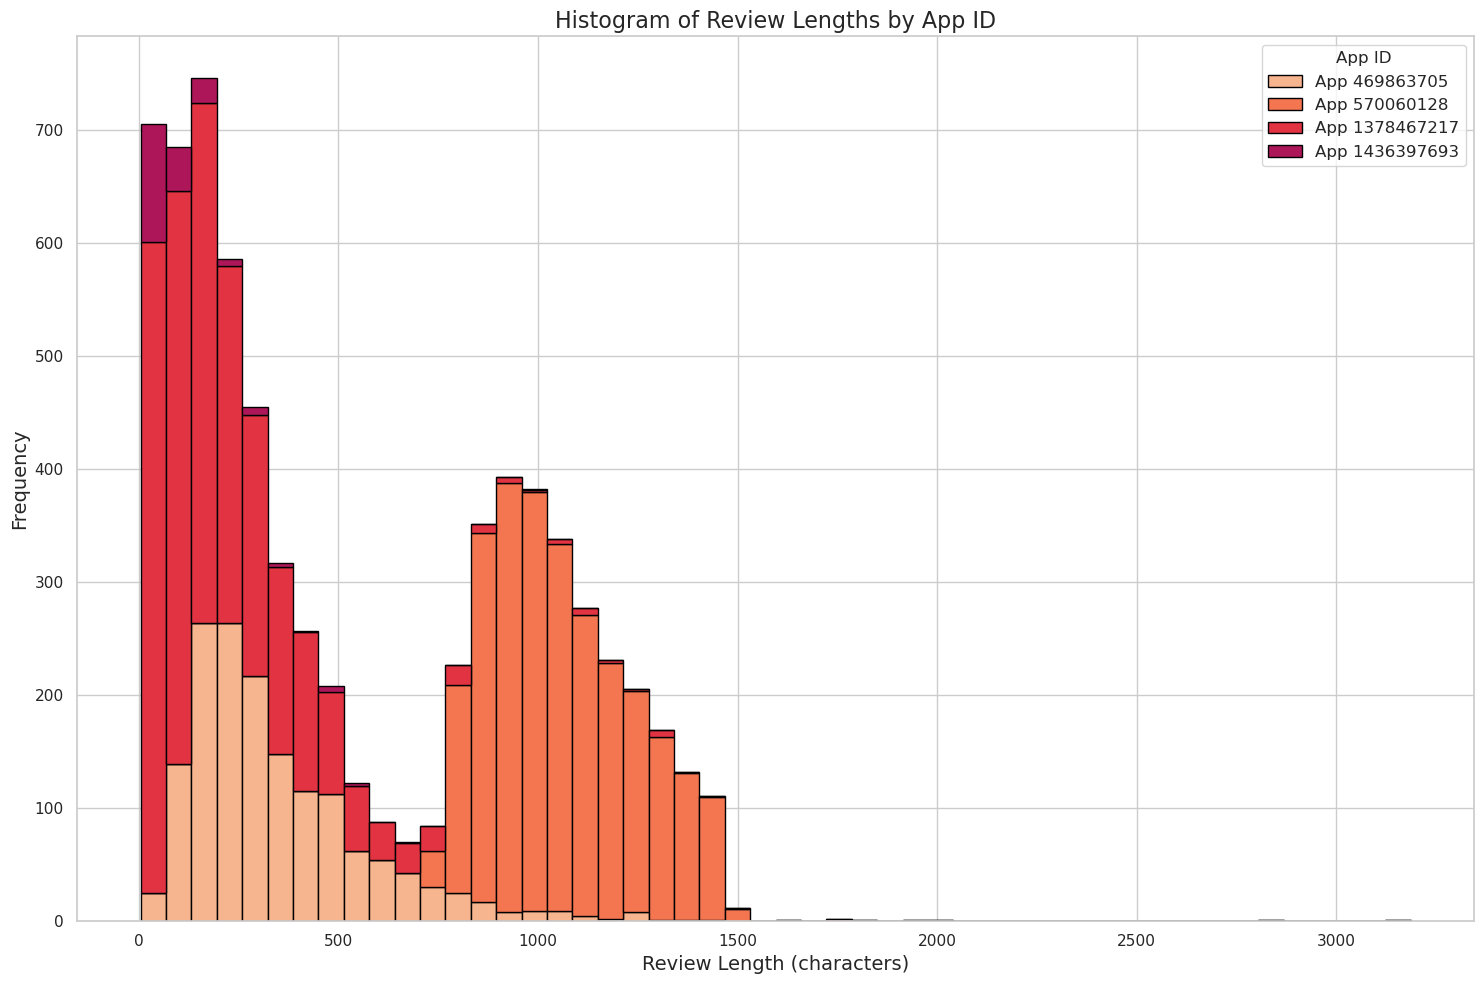

In [66]:
# Set Seaborn theme
sns.set_theme(style="whitegrid", palette="rocket_r")

# Create a figure and axis object with a larger size
fig, ax = plt.subplots(figsize=(15, 10))

# Set the number of bins
bins = 50
hist_values = []
bin_edges = None

# Group the data by 'app_id'
groups = appstore_df.groupby("app_id")

# Loop through each app_id group to collect review lengths
for app_id, group in groups:
    review_lengths = group["review"].str.len()
    hist_values.append(review_lengths)

# Create a stacked histogram
ax.hist(hist_values, bins=bins, density=False, histtype='bar', stacked=True, edgecolor='black')

# Set the title with larger font size and some styling
ax.set_title("Histogram of Review Lengths by App ID", fontsize=16)

# Set the x-axis and y-axis labels with larger font size and improved readability
ax.set_xlabel("Review Length (characters)", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)

# Add a legend with clear labels for each app_id
ax.legend([f"App {app_id}" for app_id in groups.groups.keys()], title="App ID", fontsize=12)

# Adjust layout to avoid overlap of labels and legend
plt.tight_layout()

plt.savefig("img/review_len.png", transparent=True, dpi=300, format='png')

# Show the plot
plt.show()

In [67]:
cleaned_appstore = appstore_df.loc[appstore_df["review"].str.len() > 2]

In [68]:
cleaned_appstore.shape

(7163, 15)

In [69]:
# Load the emotion detection pipeline
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True, device=device)

# Example reviews
reviews = [
    "I absolutely love this app! It's so intuitive and helpful.",
    "I'm so frustrated! It crashes every time I try to use it.",
    "This update is okay, but I expected more features.",
    "The customer support team is amazing and very responsive.",
    "I'm disappointed by the recent changes. They made the app worse."
]

# Analyze emotions
for review in reviews:
    emotions = emotion_analyzer(review)
    print(f"Review: {review}")
    print("Emotions:")
    for emotion in emotions[0]:
        print(f"  {emotion['label']}: {emotion['score']:.2f}")
    print()


Device set to use cuda
/home/bbae/miniconda3/envs/mgscfinal/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Review: I absolutely love this app! It's so intuitive and helpful.
Emotions:
  anger: 0.00
  disgust: 0.00
  fear: 0.00
  joy: 0.94
  neutral: 0.03
  sadness: 0.00
  surprise: 0.02

Review: I'm so frustrated! It crashes every time I try to use it.
Emotions:
  anger: 0.95
  disgust: 0.01
  fear: 0.00
  joy: 0.00
  neutral: 0.01
  sadness: 0.02
  surprise: 0.01

Review: This update is okay, but I expected more features.
Emotions:
  anger: 0.01
  disgust: 0.01
  fear: 0.01
  joy: 0.03
  neutral: 0.81
  sadness: 0.07
  surprise: 0.06

Review: The customer support team is amazing and very responsive.
Emotions:
  anger: 0.01
  disgust: 0.01
  fear: 0.01
  joy: 0.08
  neutral: 0.27
  sadness: 0.00
  surprise: 0.63

Review: I'm disappointed by the recent changes. They made the app worse.
Emotions:
  anger: 0.05
  disgust: 0.82
  fear: 0.00
  joy: 0.00
  neutral: 0.03
  sadness: 0.09
  surprise: 0.00



In [70]:
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None, device=device)

Device set to use cuda


In [71]:
def classify_text(text):
    # Perform classification
    results = classifier(text)
    
    # Flatten and sort results
    flat_results = results[0]  # Assuming first list contains results
    sorted_results = sorted(flat_results, key=lambda x: x['score'], reverse=True)
    
    # Top category
    top_category = sorted_results[0]['label']
    top_score = sorted_results[0]['score']
    
    # All categories as a dictionary
    category_scores = {result['label']: result['score'] for result in sorted_results}
    
    return {
        'top_category': top_category,
        'top_score': top_score,
        'all_categories': category_scores
    }

In [72]:
# sentences = first_5_reviews

# Example reviews
reviews = [
    "I absolutely love this app! It's so intuitive and helpful.",
    "I'm so frustrated! It crashes every time I try to use it.",
    "This update is okay, but I expected more features.",
    "The customer support team is amazing and very responsive.",
    "I'm disappointed by the recent changes. They made the app worse."
]

for review in reviews:
    print("Review:", review)
    classification_result = classify_text(review)
    # Print results
    print("Top Category:", classification_result['top_category'])
    print("Top Score:", classification_result['top_score'])
    print("All Categories:", classification_result['all_categories'])

Review: I absolutely love this app! It's so intuitive and helpful.
Top Category: love
Top Score: 0.8320332169532776
All Categories: {'love': 0.8320332169532776, 'admiration': 0.6481373310089111, 'approval': 0.06095840409398079, 'joy': 0.029382651671767235, 'gratitude': 0.012897741980850697, 'neutral': 0.008108608424663544, 'optimism': 0.006919011007994413, 'realization': 0.005853550508618355, 'excitement': 0.005764655768871307, 'caring': 0.005033276043832302, 'disapproval': 0.0049604373052716255, 'annoyance': 0.003059523878619075, 'confusion': 0.002897158032283187, 'desire': 0.0027606149669736624, 'disappointment': 0.0026452546007931232, 'sadness': 0.0021772554609924555, 'anger': 0.0021054015960544348, 'pride': 0.001994854072108865, 'surprise': 0.0019023247295990586, 'amusement': 0.001791193033568561, 'curiosity': 0.0017314654542133212, 'relief': 0.001094500650651753, 'disgust': 0.0010828411905094981, 'remorse': 0.0009183261427097023, 'fear': 0.0007056392496451735, 'embarrassment': 0.0

Test Run

In [73]:
app_store_reviews = cleaned_appstore["review"]

# List to store reviews and their average scores
review_data = []

def process_review(review):
    # Split and classify
    sentences = sent_tokenize(review)
    sentence_scores = []
    for sentence in sentences:
        # classifier returns list of dicts that have only one emotion key and corresponding score in each dict
        results = classifier(sentence)[0]
        # Convert the list of dictionaries into a single dictionary
        dict_scores = {d['label']: d['score'] for d in results}
        sentence_scores.append(dict_scores)
    
    # Create a DataFrame from the sentence scores
    scores_df = pd.DataFrame(sentence_scores)
    
    # Compute average scores for each emotion category
    average_scores = scores_df.mean(numeric_only=True, axis=0)
    return average_scores
    
# Apply processing to each review
emotion_averages = cleaned_appstore["review"].apply(process_review)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [74]:
emotion_averages.head()

,neutral,approval,realization,annoyance,disappointment,optimism,disapproval,admiration,sadness,confusion,...,love,surprise,curiosity,gratitude,embarrassment,anger,nervousness,remorse,pride,grief
0,0.596640,0.122042,0.015823,0.005911,0.003237,0.011316,0.004991,0.112308,0.001633,0.002466,...,0.059172,0.000844,0.002080,0.003066,0.000399,0.001172,0.000435,0.000530,0.001348,0.000324
1,0.413818,0.119802,0.035029,0.013273,0.007034,0.018145,0.027990,0.117810,0.002783,0.033922,...,0.058742,0.001952,0.096620,0.148901,0.001948,0.001935,0.000916,0.000894,0.002721,0.000562
2,0.412002,0.089891,0.013034,0.007273,0.005425,0.008518,0.006748,0.231853,0.004237,0.059407,...,0.080019,0.014132,0.003056,0.065627,0.000929,0.002260,0.000996,0.001228,0.002564,0.000487
3,0.455712,0.171768,0.048605,0.010831,0.005508,0.032074,0.061143,0.280289,0.001932,0.002863,...,0.002597,0.001427,0.001607,0.004175,0.000764,0.001391,0.001086,0.000670,0.003476,0.000543
4,0.372648,0.160608,0.046690,0.019599,0.024657,0.012663,0.021458,0.246586,0.002425,0.056619,...,0.065167,0.004764,0.005942,0.009280,0.001186,0.004200,0.000899,0.000758,0.003661,0.000578


In [75]:
# Expand the emotion averages into separate columns for each emotion
scored_appstore = pd.concat([cleaned_appstore, emotion_averages], axis=1)

In [76]:
scored_appstore.dtypes

id               int64
type            object
offset         float64
n_batch        float64
app_id           int64
                ...   
anger          float64
nervousness    float64
remorse        float64
pride          float64
grief          float64
Length: 43, dtype: object

In [77]:
# Convert Object to DateTime
scored_appstore["date"] = pd.to_datetime(scored_appstore["date"])

In [78]:
# Define the exponential decay function
def apply_exponential_decay(group, half_life=1):
    """
    Apply exponential decay to scores in the group.
    
    Parameters:
    - group: DataFrame or Series with sorted reviews and their scores.
    - half_life: The time (in units of the index) after which the score is halved.
    
    Returns:
    - A DataFrame with scores adjusted for exponential decay.
    """
    # Sort the group by date
    group = group.sort_values(by="date")
    # Calculate the decay factor: decay = 2 ^ (-index / half_life)
    # where index is the position of the review within the group
    decay_factors = np.exp(-np.arange(len(group)) / half_life)

    # Ensure that the length of decay factors matches the rows of the group
    assert len(decay_factors) == len(group), "Length mismatch between decay factors and rows in group"
    
        # Apply the decay factor to each emotion score
    for emotion in emotion_averages.columns.tolist():  # Include all emotion columns
        group[emotion] = group[emotion] * decay_factors
    
    return group

In [79]:
def time_weighted_and_normalized_score(group, reference_date, lambda_decay=0.1):

    group['date'] = pd.to_datetime(group['date'])
    reference_date = pd.to_datetime(reference_date, utc=True)
    
    # Calculate time difference from reference date (assuming 'date' column is in datetime format)
    group['time_diff'] = (reference_date - group['date']).dt.days
    
    # Apply decay based on time difference
    group['weight'] = 1 / (1 + lambda_decay * group['time_diff'])
    
    # Apply weight to each score column
    for emotion in emotion_averages.columns.tolist():
        group[emotion] = group[emotion] * group['weight']
        min_score = group[emotion].min()
        max_score = group[emotion].max()
        group[emotion] = (group[emotion] - min_score) / (max_score - min_score)

    return group

In [80]:
# scored_appstore.groupby("app_id").apply(apply_exponential_decay)

In [81]:
scored_appstore.columns

Index(['id', 'type', 'offset', 'n_batch', 'app_id', 'date',
       'developerResponse.id', 'developerResponse.body',
       'developerResponse.modified', 'review', 'rating', 'isEdited',
       'userName', 'title', 'name', 'neutral', 'approval', 'realization',
       'annoyance', 'disappointment', 'optimism', 'disapproval', 'admiration',
       'sadness', 'confusion', 'joy', 'disgust', 'desire', 'amusement', 'fear',
       'excitement', 'caring', 'relief', 'love', 'surprise', 'curiosity',
       'gratitude', 'embarrassment', 'anger', 'nervousness', 'remorse',
       'pride', 'grief'],
      dtype='object')

In [82]:
# scored_appstore.groupby("app_id").apply(time_weighted_and_normalized_score, reference_date=date.today())

In [83]:
emotion_columns = [
    'neutral', 'approval', 'realization', 'annoyance', 'disappointment', 'optimism', 
    'disapproval', 'admiration', 'sadness', 'confusion', 'joy', 'disgust', 'desire', 
    'amusement', 'fear', 'excitement', 'caring', 'relief', 'love', 'surprise', 
    'curiosity', 'gratitude', 'embarrassment', 'anger', 'nervousness', 'remorse', 
    'pride', 'grief'
]

# Group by app_id and calculate the mean for each emotion column
mean_emotion_scores = scored_appstore.groupby('app_id')[emotion_columns].mean().reset_index()

In [84]:
mean_emotion_scores

,app_id,neutral,approval,realization,annoyance,disappointment,optimism,disapproval,admiration,sadness,...,love,surprise,curiosity,gratitude,embarrassment,anger,nervousness,remorse,pride,grief
0,469863705,0.311889,0.144178,0.036452,0.042987,0.044540,0.033989,0.046151,0.189336,0.011314,...,0.076071,0.006484,0.012695,0.071394,0.002863,0.009129,0.002087,0.003146,0.003150,0.000807
1,570060128,0.378834,0.136243,0.050477,0.060759,0.058993,0.034712,0.062105,0.101210,0.016863,...,0.048791,0.006535,0.015540,0.023390,0.003274,0.011343,0.002862,0.003299,0.002676,0.000929
2,137846...,0.279002,0.111834,0.018163,0.018132,0.016330,0.017847,0.021389,0.222705,0.007335,...,0.190475,0.008128,0.010205,0.069815,0.001184,0.007027,0.000986,0.001739,0.002720,0.000649
3,143639...,0.323792,0.070379,0.015236,0.034059,0.040359,0.023645,0.052118,0.169149,0.014643,...,0.220521,0.005822,0.010989,0.028761,0.001937,0.013319,0.001669,0.001841,0.001996,0.000812


## Visualizing

In [85]:
labels = classifier.model.config.id2label
print(labels)

{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


In [86]:
# # Bar Chart for Category Distribution
# plt.figure(figsize=(8, 5))
# plt.bar(review_insights['category_distribution'].keys(), review_insights['category_distribution'].values(), color='skyblue')
# plt.title('Category Distribution')
# plt.xlabel('Categories')
# plt.ylabel('Proportion')
# plt.xticks(rotation=45)
# plt.show()

In [87]:
# plt.figure(figsize=(20, 6))
# plt.bar(['average_category_scores'].keys(), review_insights['average_category_scores'].values(), color='skyblue')
# plt.title('Category Scores')
# plt.xlabel('Categories')
# plt.ylabel('Scores')
# plt.xticks(rotation=45)
# plt.show()

## Finetuning Model

Import Hand labeled data

In [88]:
# emotions_labels = [
#     "admiration",
#     "amusement",
#     "approval",
#     "caring",
#     "anger",
#     "annoyance",
#     "disappointment",
#     "disapproval",
#     "confusion",
#     "desire",
#     "excitement",
#     "gratitude",
#     "joy",
#     "disgust",
#     "embarrassment",
#     "fear",
#     "grief",
#     "love",
#     "optimism",
#     "pride",
#     "relief",
#     "nervousness",
#     "remorse",
#     "sadness",
#     "realization",
#     "surprise",
#     "curiosity",
#     "neutral"
# ]

In [89]:
# def parse_multilabel_sentiment(sentiment_str):
#     """
#     Parse sentiment string, handling both single labels and JSON-like multi-label formats
#     """
#     try:
#         # Try parsing as JSON
#         if isinstance(sentiment_str, str) and sentiment_str.startswith('{'):
#             parsed_sentiment = json.loads(sentiment_str.replace("'", '"'))
#             return parsed_sentiment.get('choices', [sentiment_str])
        
#         # If it's a single string, return as a list
#         elif isinstance(sentiment_str, str):
#             return [sentiment_str]
        
#         # If it's already a list, return as-is
#         elif isinstance(sentiment_str, list):
#             return sentiment_str
        
#         # Default case
#         return []
#     except (json.JSONDecodeError, TypeError):
#         return [sentiment_str]

# def prepare_multilabel_emotion_classification(data_path):
#     # Load data
#     df = pd.read_csv(data_path)
    
#     # Complete list of emotions based on observed labels
#     emotions_labels = [
#         "admiration", "amusement", "anger", "annoyance", "approval", "caring", 
#         "confusion", "curiosity", "desire", "disappointment", "disapproval", 
#         "disgust", "embarrassment", "excitement", "fear", "gratitude", 
#         "grief", "joy", "love", "nervousness", "neutral", "optimism", 
#         "pride", "realization", "relief", "remorse", "sadness", "surprise"
#     ]

#     # Create label mapping
#     label_map = {emotion: index for index, emotion in enumerate(emotions_labels)}
    
#     # Parse multi-label sentiments
#     df['parsed_sentiments'] = df['sentiment'].apply(parse_multilabel_sentiment)
    
#     # Create multi-hot encoded labels
#     def create_multilabel_vector(sentiments):
#         vector = np.zeros(len(emotions_labels), dtype=np.float32)
#         for sent in sentiments:
#             if sent.strip() in label_map:
#                 vector[label_map[sent.strip()]] = 1.0
#         return vector

#     df['multilabel'] = df['parsed_sentiments'].apply(create_multilabel_vector)

#     # Tokenizer and model setup
#     model_name = "SamLowe/roberta-base-go_emotions"
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
    
#     # Prepare datasets
#     train_texts, val_texts, train_labels, val_labels = train_test_split(
#         df['sentence'], 
#         np.stack(df['multilabel']), 
#         test_size=0.2, 
#         random_state=42
#     )

#     # Custom Dataset for multi-label classification
#     class MultiLabelDataset(torch.utils.data.Dataset):
#         def __init__(self, tokenizer, texts, labels, max_length=128):
#             self.encodings = tokenizer(
#                 texts.tolist(), 
#                 truncation=True, 
#                 padding=True, 
#                 max_length=max_length, 
#                 return_tensors='pt'
#             )
#             self.labels = torch.tensor(labels, dtype=torch.float)

#         def __getitem__(self, idx):
#             item = {key: val[idx] for key, val in self.encodings.items()}
#             item['labels'] = self.labels[idx]
#             return item

#         def __len__(self):
#             return len(self.labels)

#     # Create datasets
#     train_dataset = MultiLabelDataset(tokenizer, train_texts, train_labels)
#     val_dataset = MultiLabelDataset(tokenizer, val_texts, val_labels)

#     # Load model for multi-label classification
#     model = AutoModelForSequenceClassification.from_pretrained(
#         model_name, 
#         num_labels=len(emotions_labels),
#         problem_type="multi_label_classification"
#     )

#     # Training Arguments
#     training_args = TrainingArguments(
#         output_dir="./results",
#         num_train_epochs=3,
#         per_device_train_batch_size=16,
#         per_device_eval_batch_size=16,
#         warmup_steps=500,
#         weight_decay=0.01,
#         logging_dir="./logs",
#         logging_steps=10,
#         evaluation_strategy="epoch"
#     )

#     # Custom Trainer to handle multi-label loss
#     class MultiLabelTrainer(Trainer):
#         def compute_loss(self, model, inputs, return_outputs=False):
#             # Remove labels from inputs
#             labels = inputs.pop("labels")
            
#             # Forward pass
#             outputs = model(**inputs)
            
#             # Compute binary cross-entropy loss
#             loss = F.binary_cross_entropy_with_logits(outputs.logits, labels)
            
#             return (loss, outputs) if return_outputs else loss

#     # Define a custom compute_metrics function for multi-label classification
#     def compute_metrics(pred):
#         labels = pred.label_ids
#         preds = torch.sigmoid(torch.tensor(pred.predictions)).numpy()
        
#         # Convert to binary predictions using a threshold
#         preds_binary = (preds > 0.5).astype(int)
        
#         # Compute various metrics
#         from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
        
#         return {
#             'accuracy': accuracy_score(labels, preds_binary),
#             'precision': precision_score(labels, preds_binary, average='micro'),
#             'recall': recall_score(labels, preds_binary, average='micro'),
#             'f1': f1_score(labels, preds_binary, average='micro')
#         }

#     # Initialize Trainer
#     trainer = MultiLabelTrainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#         compute_metrics=compute_metrics,
#         compute_loss_func=compute_loss
#     )

#     return trainer, train_dataset, val_dataset, label_map, emotions_labels

In [90]:
# # Prepare the data, model, and trainer
# trainer, train_dataset, val_dataset, label_map, emotions_labels = prepare_multilabel_emotion_classification("data/finetuningdata_multicategory.csv")

# # Train the model
# trainer.train()

# # Evaluate the model
# # trainer.evaluate()

In [109]:
def analyze_sentencewise_review(review):
    # Split and classify
    sentences = sent_tokenize(review)
    sentence_scores = []
    for sentence in sentences:
        # classifier returns list of dicts that have only one emotion key and corresponding score in each dict
        results = classifier(sentence)[0]
        # Convert the list of dictionaries into a single dictionary
        dict_scores = {d['label']: d['score'] for d in results}
        sentence_scores.append(dict_scores)
    
    # Create a DataFrame from the sentence scores
    scores_df = pd.DataFrame(sentence_scores)
    
    # Compute average scores for each emotion category
    average_scores = scores_df.mean(numeric_only=True, axis=0)
    return average_scores

def create_aggr_scoring(df):
    # Assumes df has "review" column containing text reviews
    # emotion_averages = df["review"].apply(analyze_sentencewise_review)
    # scored_appstore = pd.concat([df, emotion_averages], axis=1)
    # scored_appstore["date"] = pd.to_datetime(scored_appstore["date"])

    emotion_columns = [
        'neutral', 'approval', 'realization', 'annoyance', 'disappointment', 'optimism', 
        'disapproval', 'admiration', 'sadness', 'confusion', 'joy', 'disgust', 'desire', 
        'amusement', 'fear', 'excitement', 'caring', 'relief', 'love', 'surprise', 
        'curiosity', 'gratitude', 'embarrassment', 'anger', 'nervousness', 'remorse', 
        'pride', 'grief'
    ]

    score_list_dfs = []
    mean_emotion_scores = scored_appstore.groupby('app_id')[emotion_columns].mean().reset_index()
    for _, group in mean_emotion_scores.iterrows():
        sorted_group = group[emotion_columns].sort_values(ascending=False)
        score_list_dfs.append(sorted_group)

    # return a list of dfs for each group
    return score_list_dfs

In [110]:
emotion_avg = cleaned_appstore["review"].apply(analyze_sentencewise_review)

In [111]:
emotion_avg

,neutral,approval,realization,annoyance,disappointment,optimism,disapproval,admiration,sadness,confusion,...,love,surprise,curiosity,gratitude,embarrassment,anger,nervousness,remorse,pride,grief
0,0.596640,0.122042,0.015823,0.005911,0.003237,0.011316,0.004991,0.112308,0.001633,0.002466,...,0.059172,0.000844,0.002080,0.003066,0.000399,0.001172,0.000435,0.000530,0.001348,0.000324
1,0.413818,0.119802,0.035029,0.013273,0.007034,0.018145,0.027990,0.117810,0.002783,0.033922,...,0.058742,0.001952,0.096620,0.148901,0.001948,0.001935,0.000916,0.000894,0.002721,0.000562
2,0.412002,0.089891,0.013034,0.007273,0.005425,0.008518,0.006748,0.231853,0.004237,0.059407,...,0.080019,0.014132,0.003056,0.065627,0.000929,0.002260,0.000996,0.001228,0.002564,0.000487
3,0.455712,0.171768,0.048605,0.010831,0.005508,0.032074,0.061143,0.280289,0.001932,0.002863,...,0.002597,0.001427,0.001607,0.004175,0.000764,0.001391,0.001086,0.000670,0.003476,0.000543
4,0.372648,0.160608,0.046690,0.019599,0.024657,0.012663,0.021458,0.246586,0.002425,0.056619,...,0.065167,0.004764,0.005942,0.009280,0.001186,0.004200,0.000899,0.000758,0.003661,0.000578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,0.464644,0.161933,0.033696,0.025790,0.017429,0.005263,0.024669,0.006446,0.006121,0.018583,...,0.001971,0.003275,0.026279,0.001512,0.076824,0.004221,0.000763,0.006752,0.000934,0.000588
7159,0.966706,0.015170,0.006282,0.005464,0.003255,0.001889,0.004464,0.003272,0.002212,0.003327,...,0.002006,0.001054,0.001648,0.000837,0.000802,0.001941,0.000431,0.000387,0.000357,0.000464
7160,0.646806,0.014092,0.009213,0.013571,0.003467,0.005091,0.004733,0.012675,0.001439,0.061638,...,0.001251,0.206966,0.093679,0.001286,0.000961,0.002921,0.000395,0.000378,0.000367,0.000487
7161,0.027384,0.100848,0.006171,0.003020,0.002047,0.007067,0.005292,0.921589,0.001071,0.001640,...,0.009784,0.001092,0.001468,0.010249,0.000225,0.001136,0.000130,0.000352,0.002690,0.000239


In [112]:
create_aggr_scoring(pd.concat([cleaned_appstore, emotion_avg], axis=1))

[neutral           0.311889
 admiration        0.189336
 approval          0.144178
 love              0.076071
 gratitude         0.071394
 disapproval       0.046151
 disappointment    0.044540
 annoyance         0.042987
 realization       0.036452
 joy               0.035830
 optimism          0.033989
 desire            0.029314
 confusion         0.026870
 caring            0.016778
 curiosity         0.012695
 sadness           0.011314
 excitement        0.011023
 amusement         0.010446
 anger             0.009129
 surprise          0.006484
 relief            0.004844
 disgust           0.004811
 fear              0.003863
 pride             0.003150
 remorse           0.003146
 embarrassment     0.002863
 nervousness       0.002087
 grief             0.000807
 Name: 0, dtype: float64,
 neutral           0.378834
 approval          0.136243
 admiration        0.101210
 disapproval       0.062105
 annoyance         0.060759
 disappointment    0.058993
 realization       0.0